# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section3 Checkクイズの解答
- Section4　実装②
  - 4.1 FashionMNISTを用いたConditional GAN

## Section3 Checkクイズの解答
問題1: 4, 問題2: 1

In [1]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1


In [2]:
!pip install tensorflow-gpu==1.13.1 tensorflow-tensorboard==0.4.0rc3 Keras==2.1.2

     |████████████████████████████████| 345.0MB 46kB/s 
     |████████████████████████████████| 1.7MB 40.3MB/s 
     |████████████████████████████████| 307kB 54.2MB/s 
     |████████████████████████████████| 368kB 54.9MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 3.2MB 53.0MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp37-none-any.whl size=107222 sha256=fa080a90fdd895633a40973a7cf0de45da9238df34216b27459042d6178e3d6b
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensor

In [3]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

2.1.2
1.13.1


In [4]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test


def plot_mnist_conditional(n_ex=10,dim=(2, 5), figsize=(8,4), labels=range(10)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    label_batch = np.eye(10)[np.arange(10)]
    generated_images = generator.predict([noise, label_batch])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 4章 実装②

### 4.1 FashionMNISTを用いたConditional GAN

このSectionではSection3の復習として、FashionMNISTのデータを用いてConditional GANを実装をしてみましょう。

### 4.1.1 GANのモデルの作成

In [5]:
from tensorflow.keras.layers import Input, concatenate, Lambda, Reshape, Dense, Dropout, Flatten, Activation, LeakyReLU, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tqdm import tqdm

def Generator():
    nch=200
    model_input = Input(shape=[100])
    cond = Input(shape=[10])
    cond_input = concatenate([model_input, cond], axis=-1)
    
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(cond_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x)
    model_output = Activation('sigmoid')(x)
    model = Model([model_input, cond], model_output)
    # model.summary()
    
    return model

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    model_input = Input(shape=shape)
    cond = Input(shape=[10])
    
    cond_reshape = Reshape( [1, 1, 10] )(cond)
    cond_reshape = Lambda(lambda x: K.ones([28, 28, 10])*x)(cond_reshape)
    cond_input = concatenate([model_input, cond_reshape], axis=-1)
    
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(cond_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)  
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x)
    model = Model([model_input, cond], model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    cond = Input(shape=[10])
    x = generator([gan_input, cond])
    gan_output = discriminator([x, cond])
    model = Model([gan_input, cond], gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model


def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
        

def train(step=10000, BATCH_SIZE=128):

    for e in tqdm(range(step)):  
        
        image_indexes = np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)
        image_batch = X_train[image_indexes,:,:,:]  
        label_batch = y_train[image_indexes]  
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict([noise_gen, label_batch])
        
        make_trainable(discriminator,True)
        
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        label_batch = np.concatenate((label_batch, label_batch))
        
        discriminator.train_on_batch([X, label_batch], y)
        
        make_trainable(discriminator,False)
    
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        label_batch2 = np.random.randint(0, 10, size=BATCH_SIZE)
        label_batch2 = np.eye(10)[label_batch2]    
        
        GAN.train_on_batch([noise_tr, label_batch2], y2 )

Instructions for updating:
Colocations handled automatically by placer.


### 4.1.2 FashionMNISTによる学習

In [7]:
X_train, _, y_train, _ = load_mnist(data='fashion')
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

train(1000)


100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


### 4.1.3 画像の生成

それではニューラルネットに画像を生成させてみましょう。

FashionMNISTのラベルは以下のようになっています。順に表示出来ているか確認してみましょう。

|ラベル|0|1|2|3|4|5|6|7|8|9|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|アイテム|T-shirt/top|Trouser|Pullover|Dress|Coat|Sandal|Shirt|Sneaker|Bag|Ankle boot|

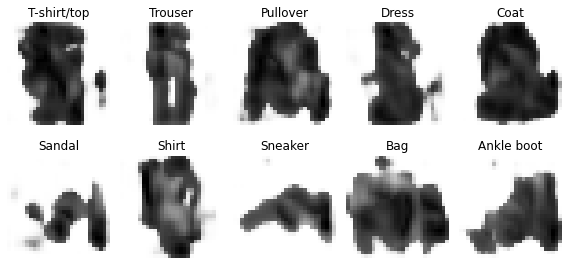

In [8]:
plot_mnist_conditional(labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

## Check実装

- 課題
    - 学習のステップの応じて生成される画像がどのように変わっていくか確かめてみましょう

In [9]:
train(2000)


100%|██████████| 2000/2000 [09:17<00:00,  3.59it/s]


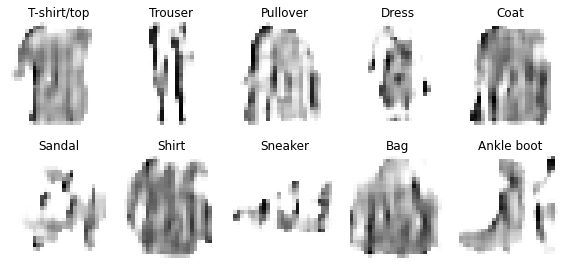

In [10]:
plot_mnist_conditional(labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])